In [20]:
import onnx
import onnxruntime

import tensorflow as tf
import keras2onnx
import efficientnet.tfkeras as enet
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

import tensorrt as trt
import pycuda.autoinit 
import pycuda.driver as cuda 

# Load model and convert to ONNX

In [ ]:
# EffNET
#Define swish here
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects

class SwishActivation(Activation):
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'
        
def swish_act(x, beta=1):
    return (x * sigmoid(beta * x))

get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

In [ ]:
model_path = 'weights/effnet_b5_weights.h5'
model = tf.keras.models.load_model(model_path, custom_objects={'SwishActivation': SwishActivation(swish_act)})

In [ ]:
# Convert keras model to onnx model
output_model_path = 'weights/effnetb5.onnx'

onnx_model = keras2onnx.convert_keras(model, model.name)
keras2onnx.save_model(onnx_model, output_model_path)

# Run inference using ONNX

In [2]:
label_map = {
    'buildings': 0,
    'forest': 1,
    'glacier': 2,
    'mountain': 3,
    'sea': 4,
    'street': 5
}

In [3]:
sess_options = onnxruntime.SessionOptions()
sess = onnxruntime.InferenceSession('weights/effnetb5.onnx', sess_options)

In [6]:
input_name = sess.get_inputs()[0].name
print("input name", input_name)
input_shape = sess.get_inputs()[0].shape
print("input shape", input_shape)
input_type = sess.get_inputs()[0].type
print("input type", input_type)

input name input_2
input shape ['N', 224, 224, 3]
input type tensor(float)


In [7]:
output_name = sess.get_outputs()[0].name
print("output name", output_name)
output_shape = sess.get_outputs()[0].shape
print("output shape", output_shape)
output_type = sess.get_outputs()[0].type
print("output type", output_type)

output name dense_5
output shape ['N', 6]
output type tensor(float)


In [8]:
images = glob.glob('data/seg_pred/seg_pred/*.jpg')

In [9]:
img = cv2.imread(images[0])
img_copy = img.copy()
img_copy = cv2.resize(img_copy, (224, 224))
img_copy = img_copy / 255.
img_copy = np.expand_dims(img_copy, axis=0)
img_copy = img_copy.astype(np.float32)

In [10]:
results = sess.run([output_name], {input_name: img_copy})

In [11]:
labels = list(label_map.keys())

In [12]:
selected_label = labels[np.argmax(np.squeeze(results))]

Text(0.5, 1.0, 'glacier')

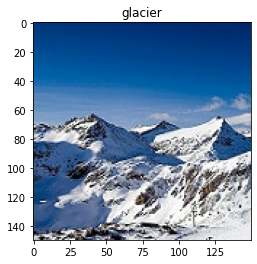

In [14]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(selected_label)

# Convert to tensorrt

In [16]:
onnx_model = onnx.load('weights/effnetb5.onnx')
onnx.checker.check_model(onnx_model)

In [21]:
TRT_LOGGER = trt.Logger()

In [32]:
def build_engine(onnx_file_path):
    builder = trt.Builder(TRT_LOGGER)
    network = builder.create_network()
    parser = trt.OnnxParser(network, TRT_LOGGER)
    
    with open(onnx_file_path, 'rb') as model:
        print('Beginning ONNX file parsing')
        parser.parse(model.read())
        
    print('Completed parsing of ONNX file')
    
    # allow TensorRT to use up to 1GB of GPU memory for tactic selection
    builder.max_workspace_size = 1 << 30
    # we have only one image in batch
    builder.max_batch_size = 1
    # use FP16 mode if possible
    if builder.platform_has_fast_fp16:
        builder.fp16_mode = True
        
    print('Building an engine...')
    engine = builder.build_cuda_engine(network)
#     context = engine.create_execution_context()
    print("Completed creating Engine")
    
    return engine

In [33]:
engine = build_engine('weights/effnetb5.onnx')

Beginning ONNX file parsing
Completed parsing of ONNX file
Building an engine...
Completed creating Engine


In [34]:
context = engine.create_execution_context()

AttributeError: 'NoneType' object has no attribute 'create_execution_context'